# Exercise 4

## Preliminaries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx, 1)

    return onehot

#example:
idx2onehot(3*torch.ones(7, dtype=torch.long),n=10)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Basics/Repetition  of VAE

In the lecture we have shown that $$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$$
where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of the decoder network $D$ and the encoder network $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient so that the average over index $l$ becomes trivial.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term for the two multivariate normal distributions can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$. The decoder produces the reconstruction `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

<span style="color:green;font-weight:bold">
Comment: <br>
In CVAE.forward the input for the encoder should be calculated with the reparametrization
    $$ z = \epsilon \cdot \sigma + \mu$$
where $\epsilon$ is sampled from a standard normal distribution, as you did, but $\sigma$ is $\text{exp}(\text{log_var}/2)$. Also it is not necessary to save the output from the encoder in the CVAE instance.<br><br>
    
In CVAE.sampling you added another parameter 'z=None', probably for the visualization of the latent space. Instead, you could simply use 'vae.decoder(z, c=c)' there.<br><br>
    
In both Encoder.__init__ and Decoder.__init__ you hardcoded the layout of the network. This is ok, since we know the number of layers beforehand, but does not generalize well. A loop would be better. <br>The last layer is a bit different from the sample solution's network and thus the 'forward' methods are a bit different, but equally correct.
</span>

In [ ]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        self.means, self.log_vars = self.encoder(x, c=c)
        self.means.to(device)
        self.log_vars.to(device)
        sample_z = torch.rand((self.means.shape)).to(device)*self.log_vars+self.means
        recon_x = self.decoder(sample_z, c=c)
        
        
        means = self.means
        log_var = self.log_vars
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return recon_x, means, log_var
        
    
    def sampling(self, n=2, c=None, z=None):
        """
        Generates new samples by feeding a random latent vector to the decoder.
        Arguments:
            n (int): amount of samples 
            c      : None or tensor of dimension (batch_size, 1) (labels to condition on)
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        if(z==None):
          sample_z = torch.rand((n, self.latent_dim)).to(device)
        else:
          if(c==None):
            sample_z = torch.Tensor(z).to(device)
          else:
            sample_z = z
        x_sampled = self.decoder(sample_z, c=c)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional the input layersize needs to be increased for the additional one-hot vector input
        if (conditional):
            layer_sizes[0]+=num_labels
        self.num_labels = num_labels
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            nn.ReLU(),
            nn.Linear(layer_sizes[2], latent_dim*2), # Since we want to learn mu and sigma
            #nn.ReLU(),
        )
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        if(c!=None):
            one_hot = idx2onehot(c, self.num_labels).to(device)
            x = torch.cat((x,one_hot), 1)
            #print(x.shape)
            
            
        result = self.model(x)
        #print(result)
        means = result[:, 0:self.latent_dim] 
        #print(means)
        log_vars = result[:, self.latent_dim:]
        #print(log_vars)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################        
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional is True, the input layersize needs to be increased for the additional one-hot vector input
        if (conditional):
            latent_dim+=num_labels
            #print(layer_sizes)
        self.num_labels = num_labels
        self.model = nn.Sequential(
            nn.Linear(latent_dim, layer_sizes[0]),
            nn.ReLU(),
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            nn.Sigmoid(),
        )
      #  torch.nn.init.xavier_uniform(self.model[0].weight)
      #  torch.nn.init.xavier_uniform(self.model[2].weight)
      #  torch.nn.init.xavier_uniform(self.model[4].weight)
        
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
            
    def forward(self, z, c=None):
        """
        Arguments:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding
        if(c!=None):
            one_hot = idx2onehot(c, self.num_labels).to(device)
            z = torch.cat((z,one_hot), 1)
        #print(z.shape)
        x=self.model(z)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return x

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

Hint: Use the following choice of hyperparameter $\sigma_G = 1$.

<span style="color:green;font-weight:bold">
Comment: The $D_{KL}$ should be calculated via the equation given in the text at the beginning
    $$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$
while the reconstruction loss should be calculated with
    $$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
where $\mu_D(z^{(i,l)})$ is 'recon_x' in the function
</span>

In [ ]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################
    # we get P_E(z|x) from the encoding function eg mu and log var
    # P(z) is the priori we fix this to a specific loaction eg N(0,1)
    # P(X,Z) we get from the decoder therfore we proceed as follows:
    
    # KL divergence
    #print(mu.shape)
    std = torch.exp(log_var /2)
    #print(std)
    #std = log_var
    p_zx = torch.distributions.Normal(mu, std) 
    p_z = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(log_var))
    z = p_zx.rsample()
    
    log_pzx = p_zx.log_prob(z)
    log_pz = p_z.log_prob(z)

    kl = (log_pzx-log_pz)
    kl = torch.sum(kl, 1)
    #print(kl.shape)
    
    
    # p(x|z) reconstruct loss
    
    
    log_scale = nn.Parameter(torch.Tensor([0.0]))
    scale = torch.exp(log_scale).to(device)
    dist = torch.distributions.Normal(recon_x, scale) # what should we really use here, it is probability, but what
    # we generate bernouli distribution
    #dist = torch.distributions.bernoulli.Bernoulli(mean)
    #print(x)
    log_pxz = dist.log_prob(x.to(device).reshape(-1, 784).to(device)).to(device)
    log_pxz = log_pxz.sum(dim=1).to(device)
    
    elbo = (kl-log_pxz)
    elbo = elbo.mean()
    return elbo
    
    

    
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################

### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The amount of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved by searching for different hyperparameters.
* Simply run the code to thrain the VAE

<span style="color:green;font-weight:bold">
Comment: The following cells were mostly given, output looks similar to the sample solution's, the answers are good
</span>

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)  

Train Epoch: 0 [0/60000 (0%)]	Loss: 382.625488
Train Epoch: 0 [12800/60000 (21%)]	Loss: 370.443298
Train Epoch: 0 [25600/60000 (43%)]	Loss: 370.876038
Train Epoch: 0 [38400/60000 (64%)]	Loss: 369.426331
Train Epoch: 0 [51200/60000 (85%)]	Loss: 369.875580
====> Epoch: 0 Average loss: 5.7933
Train Epoch: 1 [0/60000 (0%)]	Loss: 369.298828
Train Epoch: 1 [12800/60000 (21%)]	Loss: 369.236572
Train Epoch: 1 [25600/60000 (43%)]	Loss: 369.419067
Train Epoch: 1 [38400/60000 (64%)]	Loss: 368.826843
Train Epoch: 1 [51200/60000 (85%)]	Loss: 369.060852
====> Epoch: 1 Average loss: 5.7729
Train Epoch: 2 [0/60000 (0%)]	Loss: 368.386322
Train Epoch: 2 [12800/60000 (21%)]	Loss: 368.831879
Train Epoch: 2 [25600/60000 (43%)]	Loss: 369.081238
Train Epoch: 2 [38400/60000 (64%)]	Loss: 368.532776
Train Epoch: 2 [51200/60000 (85%)]	Loss: 368.776611
====> Epoch: 2 Average loss: 5.7656
Train Epoch: 3 [0/60000 (0%)]	Loss: 368.162537
Train Epoch: 3 [12800/60000 (21%)]	Loss: 368.341980
Train Epoch: 3 [25600/60000 

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 
 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

Original             Reconstructed


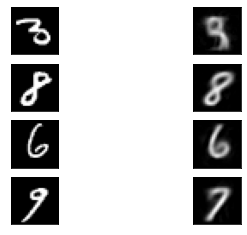

In [ ]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

We see some noise, but as we discousssed in the lecture, when using ELBO this is normal. Otherwise the edges of the numbers are slightly blurred, this is also a characteristic trait of using the squred loss eg the ELBO loss

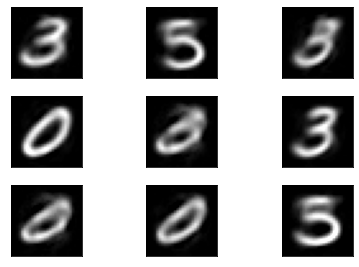

In [ ]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

### Training a second VAE with larger latent space dimension
Note that the quality of the reconstruction will also depend on the dimension of the latent space. To explore this, train a second model called `vae2` and use it to reconstruct a few example digits to evaluate the change in quality. Comment on your findings.

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 16
vae_16 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae_16 = vae_16.to(device)
optimizer = optim.Adam(vae_16.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae_16.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae_16(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)  
    


Train Epoch: 0 [0/60000 (0%)]	Loss: 381.957031
Train Epoch: 0 [12800/60000 (21%)]	Loss: 368.672699
Train Epoch: 0 [25600/60000 (43%)]	Loss: 366.829834
Train Epoch: 0 [38400/60000 (64%)]	Loss: 365.426575
Train Epoch: 0 [51200/60000 (85%)]	Loss: 364.979248
====> Epoch: 0 Average loss: 5.7442
Train Epoch: 1 [0/60000 (0%)]	Loss: 364.765717
Train Epoch: 1 [12800/60000 (21%)]	Loss: 364.693420
Train Epoch: 1 [25600/60000 (43%)]	Loss: 364.386658
Train Epoch: 1 [38400/60000 (64%)]	Loss: 363.909912
Train Epoch: 1 [51200/60000 (85%)]	Loss: 363.821106
====> Epoch: 1 Average loss: 5.6960
Train Epoch: 2 [0/60000 (0%)]	Loss: 363.854431
Train Epoch: 2 [12800/60000 (21%)]	Loss: 363.988159
Train Epoch: 2 [25600/60000 (43%)]	Loss: 363.820099
Train Epoch: 2 [38400/60000 (64%)]	Loss: 363.449860
Train Epoch: 2 [51200/60000 (85%)]	Loss: 363.437744
====> Epoch: 2 Average loss: 5.6868
Train Epoch: 3 [0/60000 (0%)]	Loss: 363.496704
Train Epoch: 3 [12800/60000 (21%)]	Loss: 363.593384
Train Epoch: 3 [25600/60000 

Original             Reconstructed


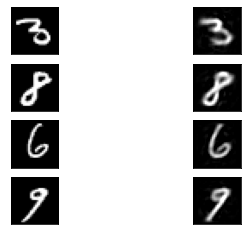

In [ ]:
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae_16(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

With increase latent space dimension ($dim(z) = 16$) the training loss is improved only slightly. Visibly, the reconstruction has slightly improved. The reconstruction of the 9 and 3 are more accurate. 

### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 381.908417
Train Epoch: 1 [12800/60000 (21%)]	Loss: 369.133667
Train Epoch: 1 [25600/60000 (43%)]	Loss: 368.560486
Train Epoch: 1 [38400/60000 (64%)]	Loss: 368.029633
Train Epoch: 1 [51200/60000 (85%)]	Loss: 367.809265
====> Epoch: 1 Average loss: 5.7672
Train Epoch: 2 [0/60000 (0%)]	Loss: 367.528992
Train Epoch: 2 [12800/60000 (21%)]	Loss: 367.717773
Train Epoch: 2 [25600/60000 (43%)]	Loss: 367.821228
Train Epoch: 2 [38400/60000 (64%)]	Loss: 367.511963
Train Epoch: 2 [51200/60000 (85%)]	Loss: 367.441040
====> Epoch: 2 Average loss: 5.7465
Train Epoch: 3 [0/60000 (0%)]	Loss: 367.252625
Train Epoch: 3 [12800/60000 (21%)]	Loss: 367.372437
Train Epoch: 3 [25600/60000 (43%)]	Loss: 367.439941
Train Epoch: 3 [38400/60000 (64%)]	Loss: 367.213959
Train Epoch: 3 [51200/60000 (85%)]	Loss: 367.141907
====> Epoch: 3 Average loss: 5.7419
Train Epoch: 4 [0/60000 (0%)]	Loss: 367.071960
Train Epoch: 4 [12800/60000 (21%)]	Loss: 367.159546
Train Epoch: 4 [25600/60000 

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

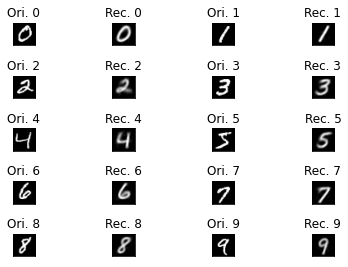

In [ ]:
x,l = next(iter(train_loader))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.long)
    plt.subplot(5,4,2*i+1)
    plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

The generated numbers look more sharp and have less fuzy parts, compared to the simple VAE. This is probably because the one hot encoding enables the network to learn a separate neural net for every numbar

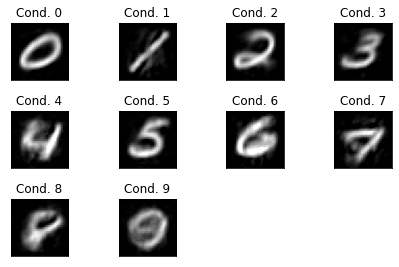

In [ ]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(1).type(torch.long)
    sample = cvae.sampling(n=1, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the model vae trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

<span style="color:green;font-weight:bold">
Comment: As mentioned above, you could use vae.decoder([x,y]) instead. With this, you could calculate the output of the decoder for all 'z' on the grid with one call by using meshgrid for example and only use the python loop for plotting. Otherwise the image looks similar
</span>

In [ ]:
def imshow_np(img, size=None):
    npimg = img
    if(size!=None):
      plt.figure(figsize=size)
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])


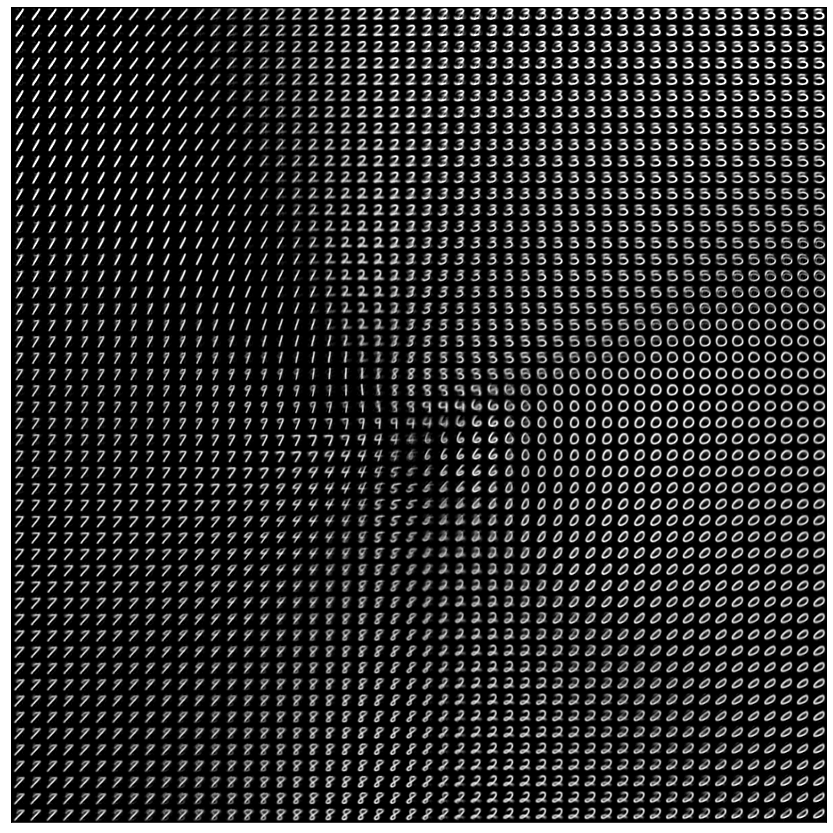

In [ ]:
########
# TODO #
########
# Visualize the latent space of the 2d latent space VAE

side =50
x_range = np.linspace(-0.1,0.1,side)
y_range = np.linspace(-0.1,0.1,side)
big_picture = np.ones((28*side, 28*side))
for idx, x in enumerate(np.linspace(-1,1,side)):
  for idy, y in enumerate(np.linspace(-1,1,side)):
    sample = vae.sampling(n=1, z=[x,y]).detach().view(-1,28,28).cpu()
    big_picture[idy*28:(idy+1)*28, idx*28:(idx+1)*28] = sample
imshow_np(big_picture, size=(15,15))
plt.show()

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

<span style="color:green;font-weight:bold">
Comment: As you mentioned, the individual labels should be non-overlapping, but the overall shape should be gaussian. Otherwise, this and the next plot look good.
</span>

I believe ideally we should get Some well defined non overlapping space, probably a grid.

No handles with labels found to put in legend.


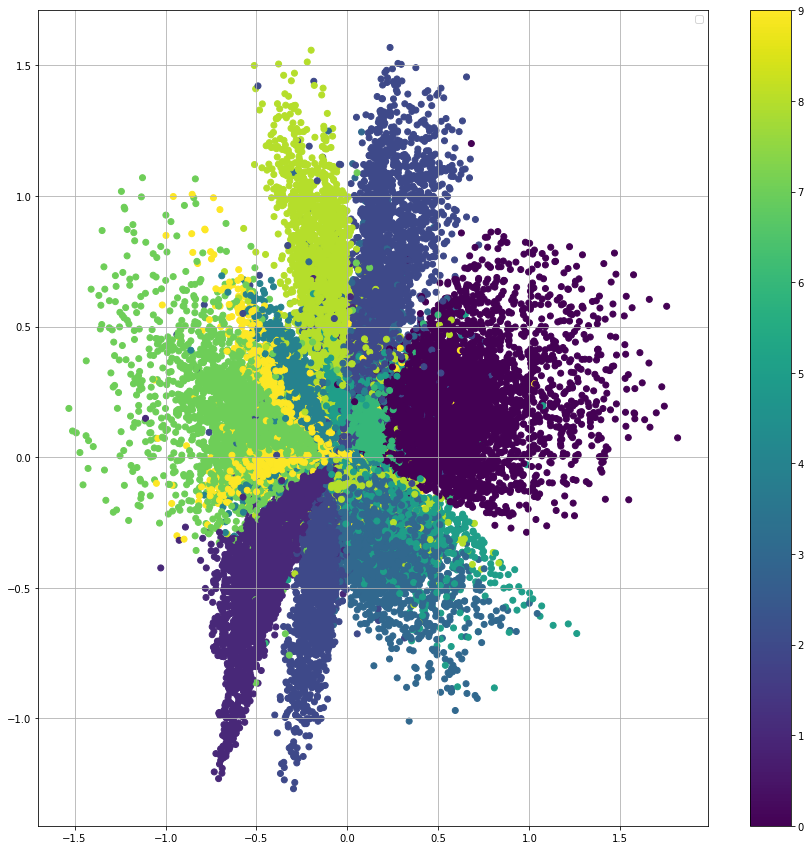

In [ ]:
########
# TODO #
########
# Plot every image from the MNIST
#print(train_dataset[0])
plt.figure(figsize=(15,15))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
for id, batch in enumerate(train_loader):
  #imshow(x.reshape((28,28)))
  x,y = batch
  x.to(device)
  #vae.to('cpu')
  x = x.view(-1,784).to(device)
  mu, sigma = vae.encoder.forward(x)
  sample_z = torch.rand((mu.shape)).to(device)*sigma+mu
  plt.scatter(sample_z[:,0].to('cpu').detach().numpy(), sample_z[:,1].to('cpu').detach().numpy(), c=y.detach().numpy())

for id, batch in enumerate(test_loader):
  #imshow(x.reshape((28,28)))
  x,y = batch
  x.to(device)
  x = x.view(-1,784).to(device)
  mu, sigma = vae.encoder.forward(x)
  sample_z = torch.rand((mu.shape)).to(device)*sigma+mu
  plt.scatter(sample_z[:,0].to('cpu').detach().numpy(), sample_z[:,1].to('cpu').detach().numpy(), c=y.detach().numpy())

plt.legend()
plt.colorbar()
plt.grid()
plt.show()

#TODO use pandas for plotting so that we can easily add a legend without sorting 
#Alternatively follow this to add a descrete color bar: https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar


Unfortunetally we see that there is quite large overlap between the the different numbers, and they are all mixed together in the middle. 

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that migh cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

It is likely that at places where a many color mix, the produced number is going to be hard, to recognize. The reason for that is probably, that those numbers tend to look simmilar. Furthermore at places where no number is mapped, eg shows white on the plot is probably also interesting. Probably those number do not represent number but various other forms

We ilustrate decoding the (-0.7,0) point

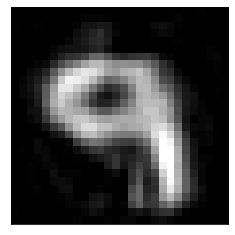

In [ ]:
########
# TODO #
########
vae.to(device)

sample = vae.sampling(n=1, z=[-0.7,0])
imshow_np(sample.to('cpu').detach().numpy().reshape((28,28)))



As we can see on the graph, as expected this indeed a mix between a 1 and an 8 and probably some other numbers

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the model cvae trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

<span style="color:green;font-weight:bold">
Comment: Same as above, plots are fine
</span>

tensor([4])


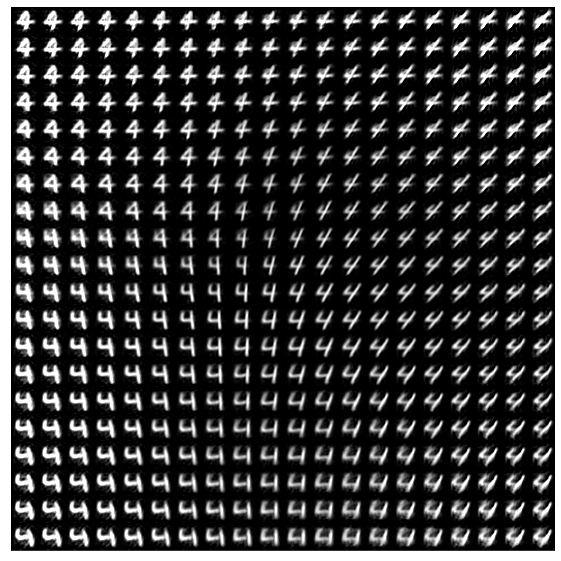

tensor([9])


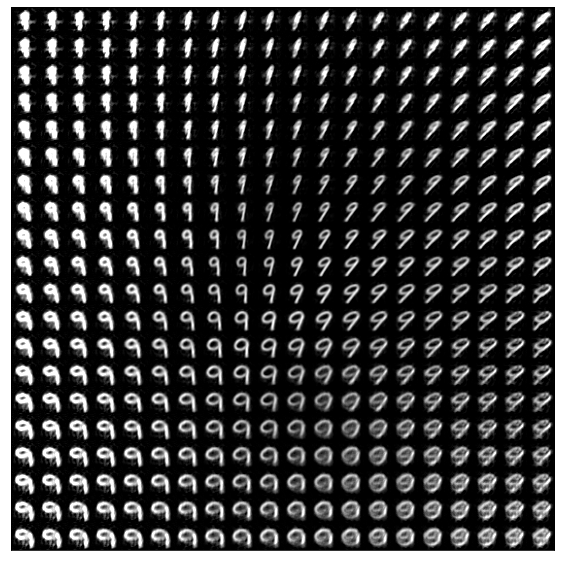

In [ ]:
########
# TODO #
########
# cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )
# cvae.to(device)

side =20
x_range = np.linspace(-0.4,0.4,side)
y_range = np.linspace(-0.4,0.4,side)
big_picture = np.ones((28*side, 28*side))
label =  4* torch.ones(1).type(torch.long)

print(label)
for idx, x in enumerate(np.linspace(-1,1,side)):
  for idy, y in enumerate(np.linspace(-1,1,side)):
    z = torch.Tensor([[x, y]]).to(device)
    sample = cvae.sampling(n=1, z=z, c=label).detach().view(-1,28,28).cpu()
    big_picture[idy*28:(idy+1)*28, idx*28:(idx+1)*28] = sample
imshow_np(big_picture, size=(10,10))
plt.show()

label =  9* torch.ones(1).type(torch.long)

print(label)
for idx, x in enumerate(np.linspace(-1,1,side)):
  for idy, y in enumerate(np.linspace(-1,1,side)):
    z = torch.Tensor([[x, y]]).to(device)
    sample = cvae.sampling(n=1, z=z, c=label).detach().view(-1,28,28).cpu()
    big_picture[idy*28:(idy+1)*28, idx*28:(idx+1)*28] = sample
imshow_np(big_picture, size=(10,10))
plt.show()

### Visualisation of Latent Space via Decoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


<span style="color:green;font-weight:bold">
Comment: You mention, that all labels result in a uniform distribution. I assume, you mean a normal distribution. Apart from that, it would be nice if you did 10 plots - one plot for each label. From your plot it is not really visible, if they actually all result in a normal distribution
</span>

No handles with labels found to put in legend.


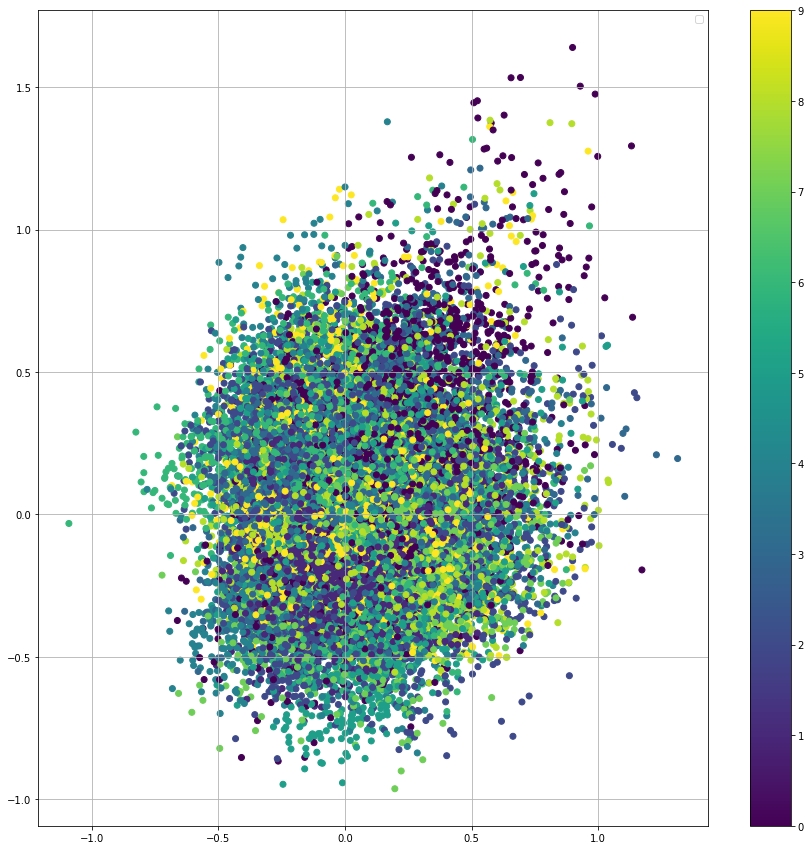

In [ ]:
########
# TODO #
########
# Plot every image from the MNIST
#print(train_dataset[0])
plt.figure(figsize=(15,15))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
for id, batch in enumerate(train_loader):
  #imshow(x.reshape((28,28)))
  x,y = batch
  label =  y* torch.ones(1).type(torch.long)
  x.to(device)
  x = x.view(-1,784).to(device)
  mu, sigma = cvae.encoder.forward(x, c=label)
  sample_z = torch.rand((mu.shape)).to(device)*sigma+mu
  plt.scatter(sample_z[:,0].to('cpu').detach().numpy(), sample_z[:,1].to('cpu').detach().numpy(), c=y.detach().numpy())

for id, batch in enumerate(test_loader):
  #imshow(x.reshape((28,28)))
  x,y = batch
  label =  y* torch.ones(1).type(torch.long)
  x.to(device)
  x = x.view(-1,784).to(device)
  mu, sigma = cvae.encoder.forward(x, c=label)
  sample_z = torch.rand((mu.shape)).to(device)*sigma+mu
  plt.scatter(sample_z[:,0].to('cpu').detach().numpy(), sample_z[:,1].to('cpu').detach().numpy(), c=y.detach().numpy())

plt.legend()
plt.colorbar()
plt.grid()
plt.show()

Compared to the standard VEA we see that the distribution of the mapping for every number into the latent space seems to be the same - uniform around 0,0

In our opinion this is due to the fact that we effectively train 10 different networks, that are not interfering with each other - when 1 is active only 1 will be learned, there is no neeed to differentiate 1 from a 2. For bad samples tihs means, that they are going to be only found further from the 0,0 there will be no bad samples around the origo

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule. The label $\hat y$ for a given ..$x$ is predicted according to:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y) \ ,$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ in the following way: Given an input image, run the CVAE 10 times, each time conditioning one one of the different class labels $y$. Calculate the losses for each case and use them to design a classifier. Note that the network was never trained as classifier, but is still able to perform the task.  

<span style="color:green;font-weight:bold">
Comment: You calculated the misclassification for each batch individually and only as the number of misclassification. It would be firstly better if you printed the percentage, as this is easier to understand. Also, the total performance over the whole test set would be better. Additionally, a confusion matrix would be nice, to see which number was misclassified as which number.
</span>

In [ ]:
########
# TODO #
########
def classify_CVAE(x):
  loss = 100000
  best_cat = -1
  for a in range(0, 10):
    label =  a*torch.ones(1).type(torch.long)
    recon_x, mu, sigma = cvae.forward(x, c = label)
    plt.show()
    tmp = loss_function(recon_x, x, mu, sigma).cpu().detach().numpy() 
    #print(sample_z)
    if (tmp < loss):
      loss = tmp
      best_cat = a;
  return best_cat

for id, batch in enumerate(test_loader):
  x,y = batch
  x = x.view(-1,784).to(device)
  loss = 0
  for b_id, number in enumerate(x):
    cat = classify_CVAE(number)
    if cat != y[b_id]:
      plt.show()
      loss +=1
  print("In batch {} loss: {}/{}".format(id, loss, batch_size))

#TODO this is VERY inffecient, could you vectorize it?



In batch 0 loss: 7/128
In batch 1 loss: 9/128
In batch 2 loss: 7/128
In batch 3 loss: 11/128
In batch 4 loss: 14/128
In batch 5 loss: 9/128
In batch 6 loss: 10/128
In batch 7 loss: 15/128
In batch 8 loss: 15/128
In batch 9 loss: 18/128
In batch 10 loss: 12/128
In batch 11 loss: 9/128
In batch 12 loss: 11/128
In batch 13 loss: 13/128
In batch 14 loss: 8/128
In batch 15 loss: 7/128
In batch 16 loss: 19/128
In batch 17 loss: 11/128
In batch 18 loss: 12/128
In batch 19 loss: 10/128
In batch 20 loss: 7/128
In batch 21 loss: 11/128
In batch 22 loss: 7/128
In batch 23 loss: 9/128
In batch 24 loss: 11/128
In batch 25 loss: 8/128
In batch 26 loss: 7/128
In batch 27 loss: 14/128
In batch 28 loss: 12/128
In batch 29 loss: 21/128
In batch 30 loss: 11/128
In batch 31 loss: 20/128
In batch 32 loss: 9/128
In batch 33 loss: 11/128
In batch 34 loss: 12/128
In batch 35 loss: 10/128
In batch 36 loss: 7/128
In batch 37 loss: 8/128
In batch 38 loss: 9/128
In batch 39 loss: 5/128
In batch 40 loss: 5/128
In 